# BSCaptcha
The objective as seen from the readme is to find how effective are captchas in the age of AI and deep learning.

In [1]:
# All the necessary imports
import cntk
from tqdm import tqdm
from captcha.image import ImageCaptcha
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

Define the possible characters that we will use in the captcha. You can change this as you wish, but be careful, that it will lead to a different architecture as well.

`n_len` is the number of characters in each captcha. This strictly defines the structure of the neural network. The number of dense branches will depend on this factor.

In [2]:
characters = string.digits + string.ascii_uppercase
n_len = 4    # Changing this will need changes in a lot of places.
width, height, n_class, batch_size = 170, 80, len(characters), 32

Create a generator that will help in feeding and creating the dataset. This is an artificial dataset built using the `captcha` library from [captcha-pypi](https://pypi.python.org/pypi/captcha/0.1.1) [captcha-repo](https://github.com/lepture/captcha)

In [3]:
def data_generator(batch_size=64):
    X = np.zeros((batch_size, 3, height, width), dtype=np.float32)
    y = [np.zeros((batch_size, n_class), dtype=np.float32) for i in range(n_len)]
    
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(n_len)])
            generator = ImageCaptcha(width=width, height=height)
            image = generator.generate_image(random_str)
            # Reshape it in a way that CNTK and our model understands
            X[i] = np.asarray(image).reshape((3, height, width))
            # One hot encoding the output labels.
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

Decodes the one hot encoded data in a human readable format

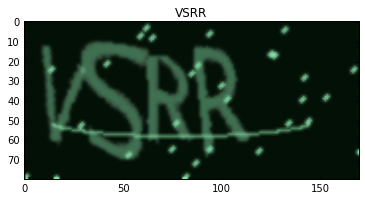

In [4]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(data_generator(1))
plt.imshow(X[0].reshape((height, width, 3)))
plt.title(decode(y))

# Neural Network Model
The model is inspired from the VGG architecture with increasing number of filters as the we progress through the layers. The convolutional base is a shared base, with dense layers branching out that are responsible to predict each character in the captcha

In [5]:
def create_model(features):
    h = features
    with cntk.layers.default_options(init=cntk.glorot_uniform(), activation=cntk.relu):
        for i in range(4):
            h = cntk.layers.Convolution2D((3, 3), num_filters=32*2**1, name='Conv{}'.format(i))(h)
            h = cntk.layers.Convolution2D((3, 3), num_filters=32*2**1, name='Conv{}'.format(i))(h)

            h = cntk.layers.MaxPooling(filter_shape=(2, 2), name='MaxPool{}'.format(i))(h)
            
        h = cntk.layers.Dropout(dropout_rate=0.25)(h)
    with cntk.layers.default_options(activation=None):
        h1 = cntk.layers.Dense(n_class, name='Dense1')(h)
        
        h2 = cntk.layers.Dense(n_class, name='Dense2')(h)
        
        h3 = cntk.layers.Dense(n_class, name='Dense3')(h)
        
        h4 = cntk.layers.Dense(n_class, name='Dense4')(h)
        
        final_model = cntk.combine(h1, h2, h3, h4)
        return final_model

A very hacky solution to what I am trying to achieve. Here each `output_placeholder` is responsible for one of the dense layers in the network at the end.

In [6]:
input_placeholder = cntk.input_variable(shape=(3, height, width))
output_placeholder0 = cntk.input_variable(shape=n_class)
output_placeholder1 = cntk.input_variable(shape=n_class)
output_placeholder2 = cntk.input_variable(shape=n_class)
output_placeholder3 = cntk.input_variable(shape=n_class)

In [7]:
z = create_model(input_placeholder/255.0)
cntk.logging.plot(z, 'native_cntk_model.png')

'Dense(Parameter1552, Parameter1553, Block1069_Output_0) -> Block1578_Output_0;\n\nDense(Parameter1423, Parameter1424, Block1069_Output_0) -> Block1449_Output_0;\n\nDense(Parameter1294, Parameter1295, Block1069_Output_0) -> Block1320_Output_0;\n\nElementDivide(Input3, ) -> Block17_Output_0;\n\nConvolution(Parameter24, Parameter25, Block17_Output_0) -> Block57_Output_0;\n\nConvolution(Parameter79, Parameter80, Block57_Output_0) -> Block112_Output_0;\n\nMaxPooling(Block112_Output_0) -> Block159_Output_0;\n\nConvolution(Parameter191, Parameter192, Block159_Output_0) -> Block224_Output_0;\n\nConvolution(Parameter266, Parameter267, Block224_Output_0) -> Block299_Output_0;\n\nMaxPooling(Block299_Output_0) -> Block366_Output_0;\n\nConvolution(Parameter418, Parameter419, Block366_Output_0) -> Block451_Output_0;\n\nConvolution(Parameter513, Parameter514, Block451_Output_0) -> Block546_Output_0;\n\nMaxPooling(Block546_Output_0) -> Block633_Output_0;\n\nConvolution(Parameter705, Parameter706, Blo

In [8]:
z.outputs

(Output('Dense1', [#], [36]),
 Output('Dense2', [#], [36]),
 Output('Dense3', [#], [36]),
 Output('Dense4', [#], [36]))

Another hacky solution for the loss and classification errors. Each of the loss/classification_error is responsible for one of the dense branches.
The final loss/classification_error is a sum over the individual losses/classification_errors

In [9]:
loss0 = cntk.cross_entropy_with_softmax(z.outputs[0], output_placeholder0)
loss1 = cntk.cross_entropy_with_softmax(z.outputs[1], output_placeholder1)
loss2 = cntk.cross_entropy_with_softmax(z.outputs[2], output_placeholder2)
loss3 = cntk.cross_entropy_with_softmax(z.outputs[3], output_placeholder3)

loss = loss0 + loss1 + loss2 + loss3

In [10]:
label_error1 = cntk.classification_error(z.outputs[0], output_placeholder0)
label_error2 = cntk.classification_error(z.outputs[1], output_placeholder1)
label_error3 = cntk.classification_error(z.outputs[2], output_placeholder2)
label_error4 = cntk.classification_error(z.outputs[3], output_placeholder3)

label_error = label_error1 + label_error2 + label_error3 + label_error4

Describe the neural network optimizers, and other hyperparameters

In [11]:
learning_rate = 1.0
# lr_schedule = cntk.learning_parameter_schedule(learning_rate)

learner = cntk.adadelta(z.parameters, lr=learning_rate, rho=0.95)

num_epox = 100
num_batches_per_epoch = 800

# progress_printer = cntk.logging.ProgressPrinter(10)
trainer = cntk.Trainer(z, (loss, label_error), [learner])

A simple code to test the model for 1 sample. This allows us to easily visualize the learning

In [12]:
def test_with_image():
    test_x, test_y = next(data_generator(1))
    evaled = z.eval({input_placeholder:test_x})
    temp = []
    for key, value in evaled.items():
        temp.append(value)
    out = cntk.softmax(temp).eval()
    plt.title('real: %s\npred:%s'%(decode(test_y), decode(out)))
    plt.imshow(test_x[0].reshape((height, width, 3)), cmap='gray')
    plt.axis('off')
    plt.show()

# Training
We used tqdm just to prettify our output.

Each of the `output_placeholder` is fed data from its respective item from the list of output labels `y`

PS: yes this is going to be long. I have shown the gradual steps that the network takes to learn the data.

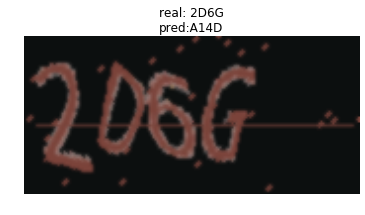

Epoch 1/50: 100%|███████████████████████████████████████| 800/800 [04:23<00:00,  3.04it/s]


11.3250226974


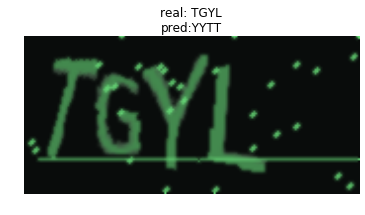

Epoch 2/50: 100%|███████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

10.4292106628


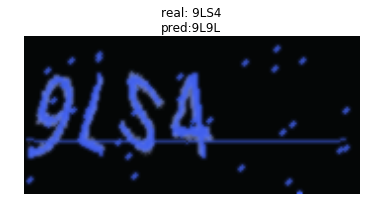

Epoch 3/50: 100%|███████████████████████████████████████| 800/800 [04:20<00:00,  3.08it/s]

8.0231552124


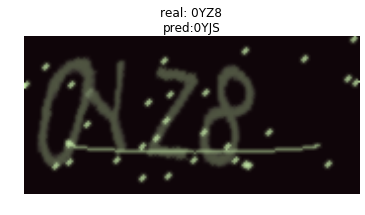

Epoch 4/50: 100%|███████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

7.52128982544


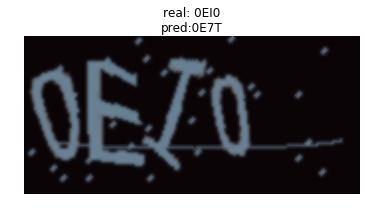

Epoch 5/50: 100%|███████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

7.19963264465


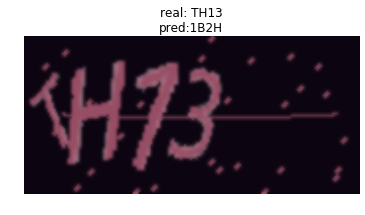

Epoch 6/50: 100%|███████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

6.27229976654


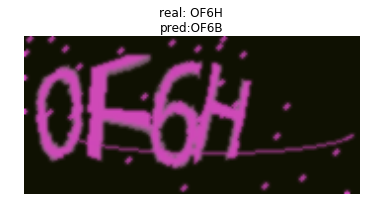

Epoch 7/50: 100%|███████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

6.81076002121


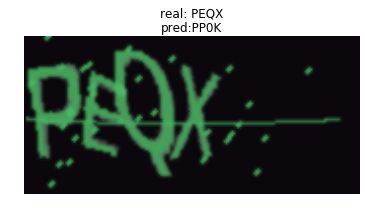

Epoch 8/50: 100%|███████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

6.52172279358


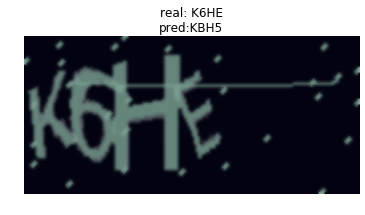

Epoch 9/50: 100%|███████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

6.77953958511


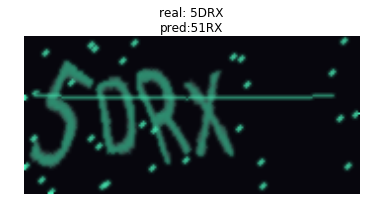

Epoch 10/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

6.61246204376


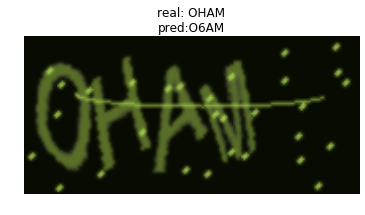

Epoch 11/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

6.3050365448


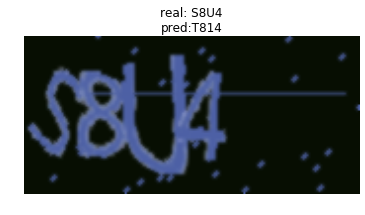

Epoch 12/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

5.59650850296


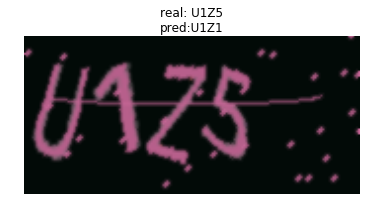

Epoch 13/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

5.91756820679


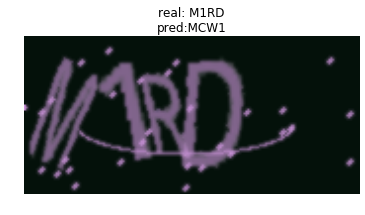

Epoch 14/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

5.06845378876


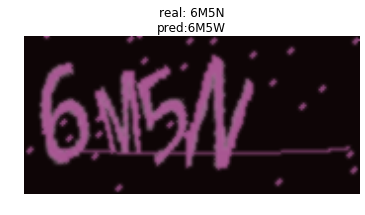

Epoch 15/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.07it/s]

6.0663766861


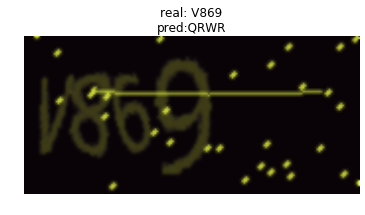

Epoch 16/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

5.981112957


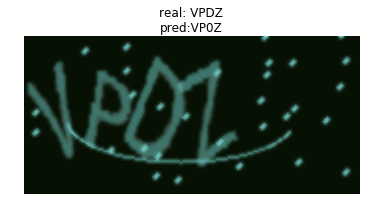

Epoch 17/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

5.38664722443


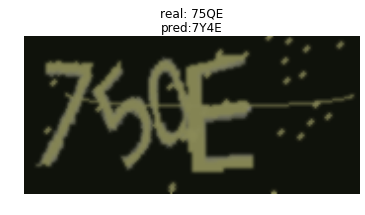

Epoch 18/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

5.42809963226


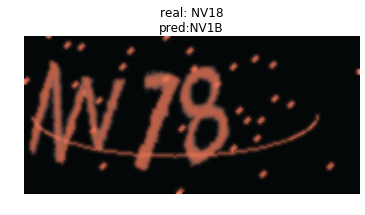

Epoch 19/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

5.1235294342


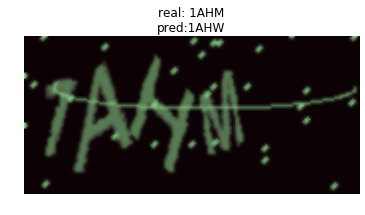

Epoch 20/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

4.57506370544


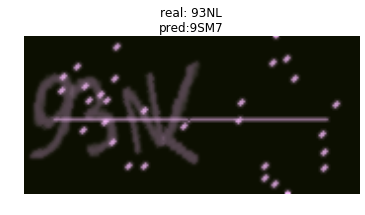

Epoch 21/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

5.13726806641


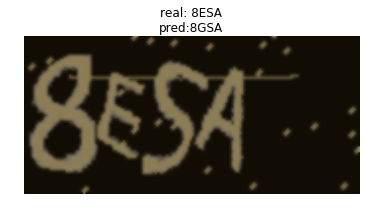

Epoch 22/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

5.36468935013


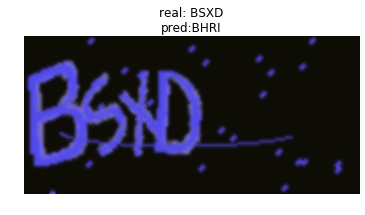

Epoch 23/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

5.85048961639


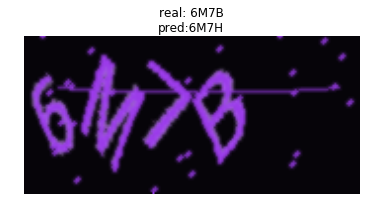

Epoch 24/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

4.34271240234


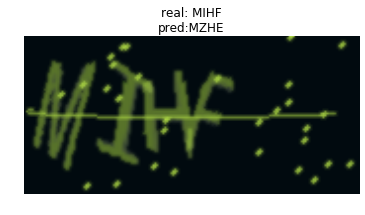

Epoch 25/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

6.00553321838


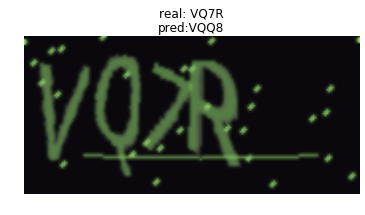

Epoch 26/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

4.92385625839


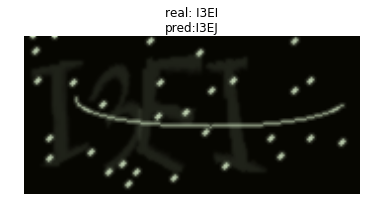

Epoch 27/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

4.7376666069


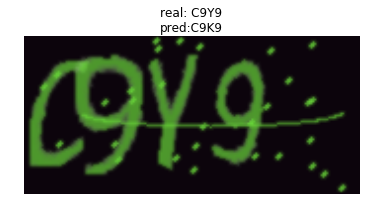

Epoch 28/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

5.19463348389


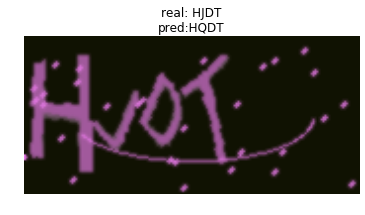

Epoch 29/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

4.72195577621


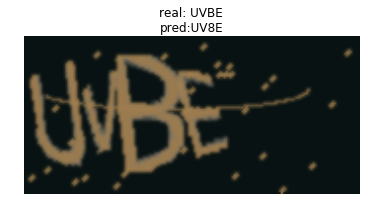

Epoch 30/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

4.56581258774


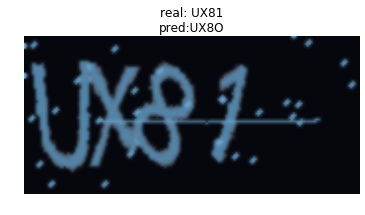

Epoch 31/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

5.09526586533


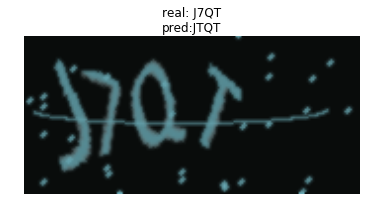

Epoch 32/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

4.42542552948


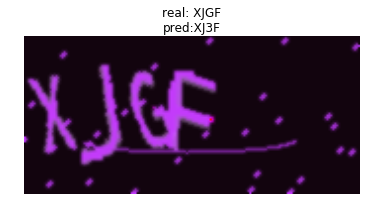

Epoch 33/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

4.49313592911


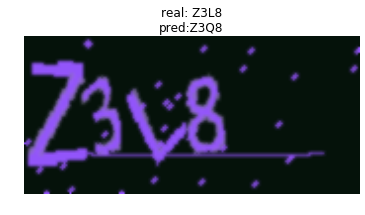

Epoch 34/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

4.26418590546


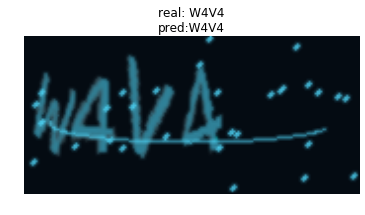

Epoch 35/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

4.5448307991


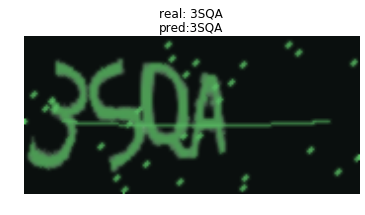

Epoch 36/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

4.83058071136


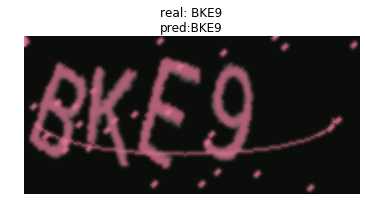

Epoch 37/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

4.19364595413


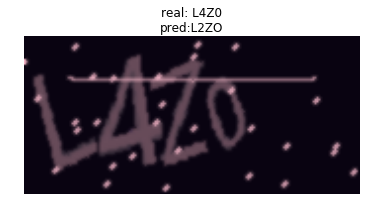

Epoch 38/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

4.32803487778


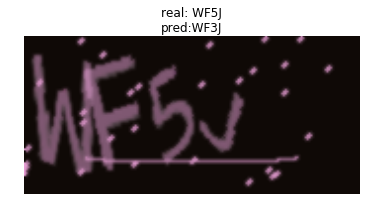

Epoch 39/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

4.62596416473


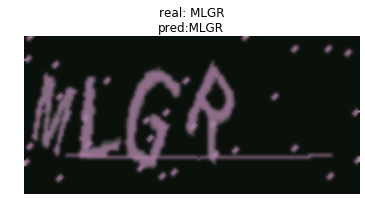

Epoch 40/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.07it/s]

3.34943199158


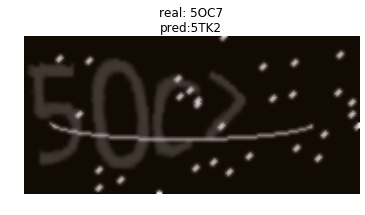

Epoch 41/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

4.08182430267


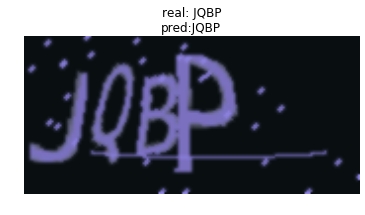

Epoch 42/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

4.20930576324


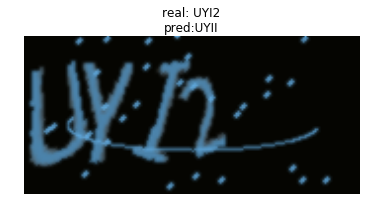

Epoch 43/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.22019529343


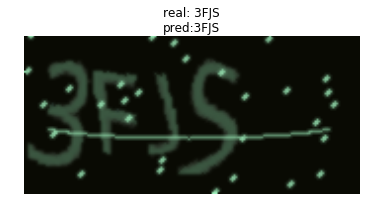

Epoch 44/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

4.39581203461


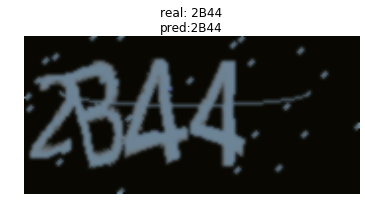

Epoch 45/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.67146682739


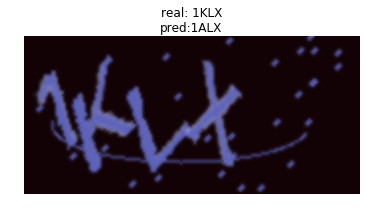

Epoch 46/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.87298202515


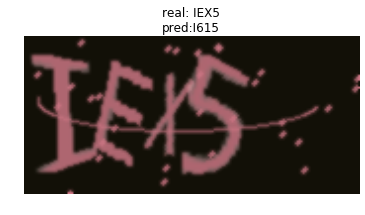

Epoch 47/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

3.54525089264


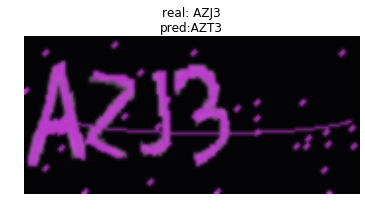

Epoch 48/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

4.5156750679


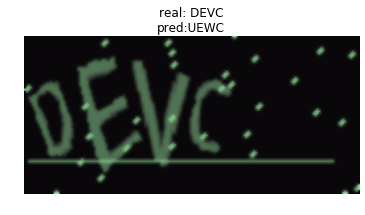

Epoch 49/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

3.47769212723


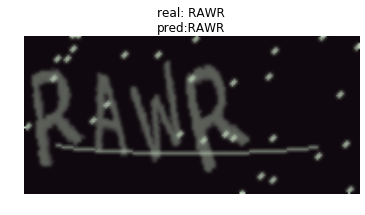

Epoch 50/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

3.84375619888


In [13]:
for epoch_number in range(num_epox):
    test_with_image()
    for batch in tqdm(
            range(num_batches_per_epoch),
            ncols=90,
            smoothing=1,
            desc='Epoch {}/{}'.format((epoch_number + 1), num_epox)):
        x, y = next(data_generator(batch_size))
        
        minibatch_losses = []
        trainer.train_minibatch(
            {
                input_placeholder: x,
                output_placeholder0: y[0],
                output_placeholder1: y[1],
                output_placeholder2: y[2],
                output_placeholder3: y[3]
            }
        )
        minibatch_losses.append(trainer.previous_minibatch_loss_average)
    print(np.mean(minibatch_losses))

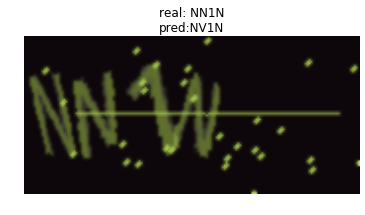

In [14]:
test_with_image()

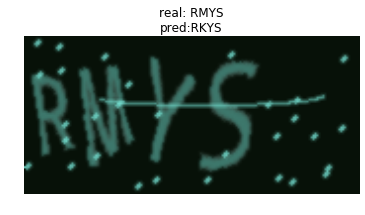

Epoch 1/50: 100%|███████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.00405502319


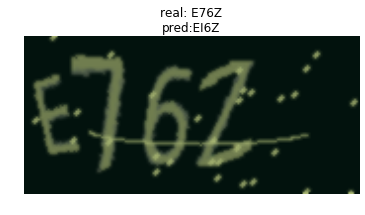

Epoch 2/50: 100%|███████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.56416940689


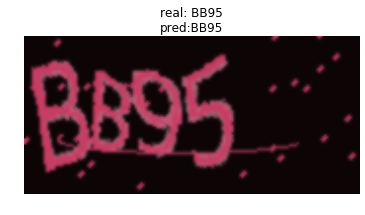

Epoch 3/50: 100%|███████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.21975708008


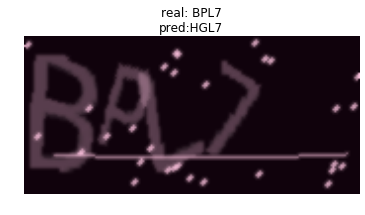

Epoch 4/50: 100%|███████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.95019245148


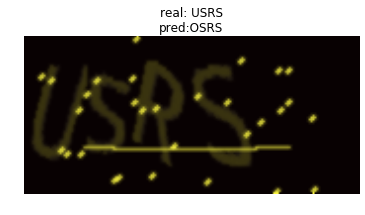

Epoch 5/50: 100%|███████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

4.13640975952


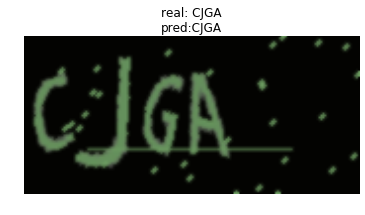

Epoch 6/50: 100%|███████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

3.80178260803


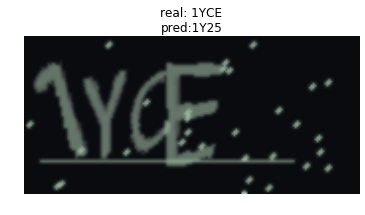

Epoch 7/50: 100%|███████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

4.17475748062


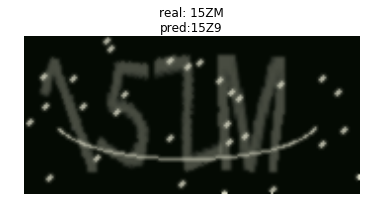

Epoch 8/50: 100%|███████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

3.46116828918


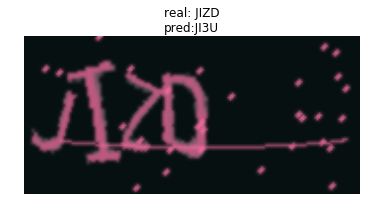

Epoch 9/50: 100%|███████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.84072971344


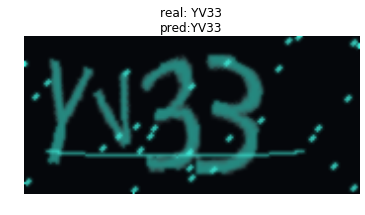

Epoch 10/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

2.94851541519


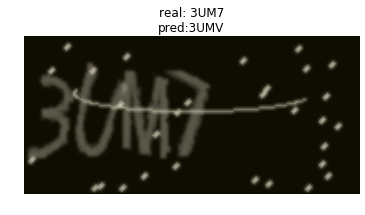

Epoch 11/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

4.34357595444


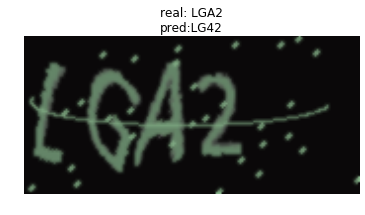

Epoch 12/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.78207492828


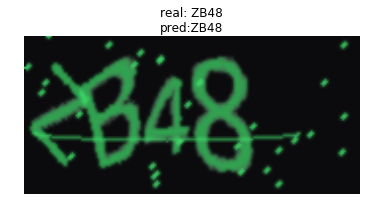

Epoch 13/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.7375831604


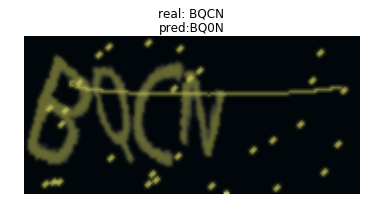

Epoch 14/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.13233470917


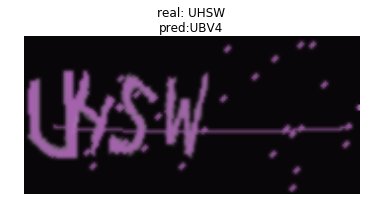

Epoch 15/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.59665060043


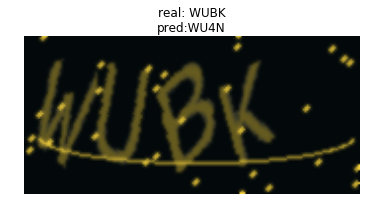

Epoch 16/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.20899248123


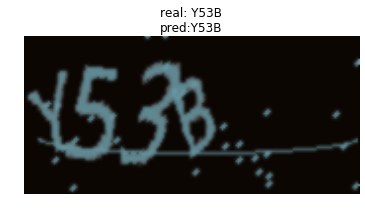

Epoch 17/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.35465764999


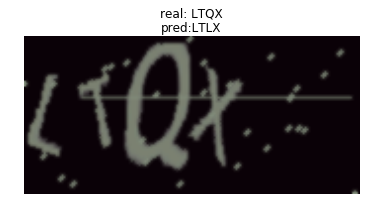

Epoch 18/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.05221176147


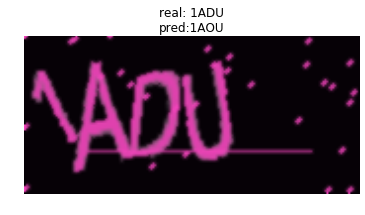

Epoch 19/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

2.86688184738


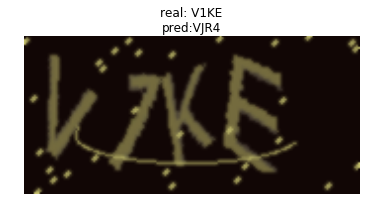

Epoch 20/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.62550354004


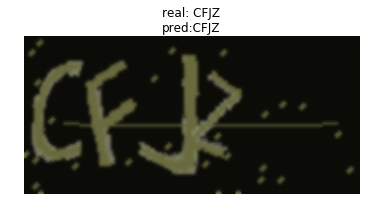

Epoch 21/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.00866270065


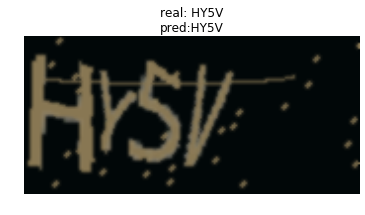

Epoch 22/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

3.19861698151


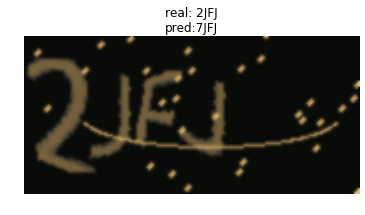

Epoch 23/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

3.48136901855


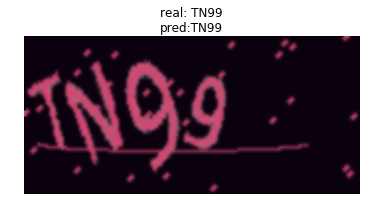

Epoch 24/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

4.27063941956


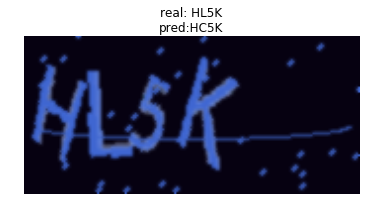

Epoch 25/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

2.80070066452


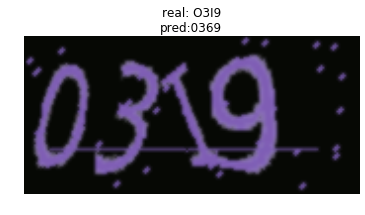

Epoch 26/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.14808177948


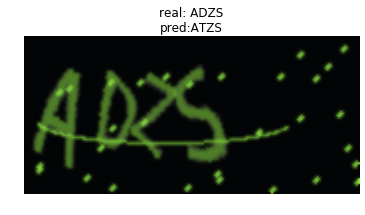

Epoch 27/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.56723117828


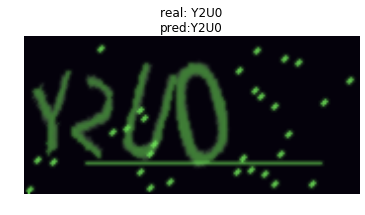

Epoch 28/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.49311733246


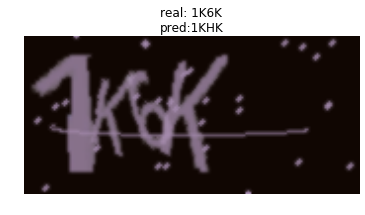

Epoch 29/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

3.40815448761


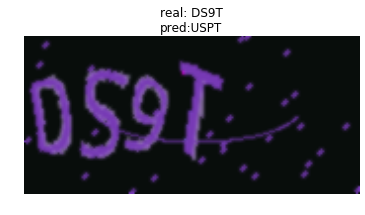

Epoch 30/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

3.32366132736


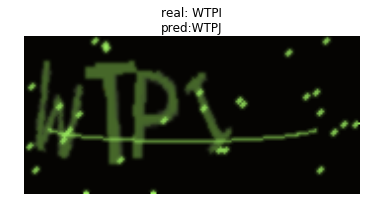

Epoch 31/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

3.78190040588


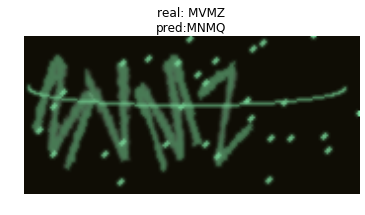

Epoch 32/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

3.27514076233


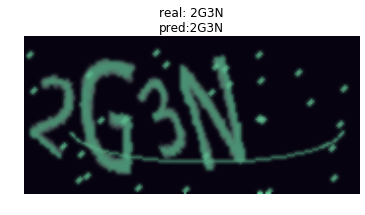

Epoch 33/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

3.62375068665


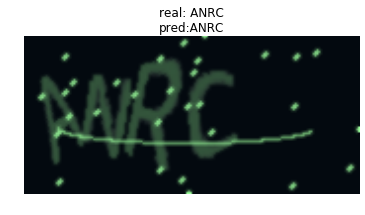

Epoch 34/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

3.38562011719


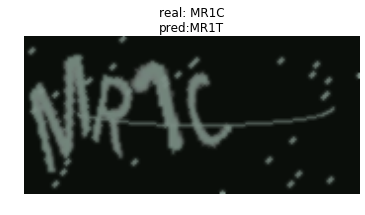

Epoch 35/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

2.68692398071


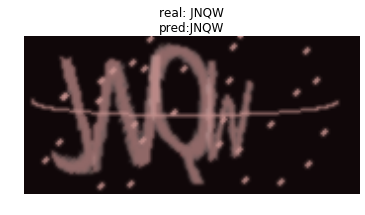

Epoch 36/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.6834564209


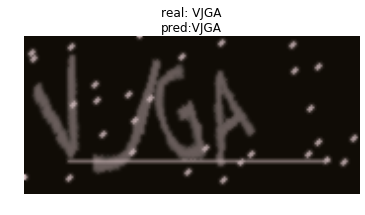

Epoch 37/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

2.93999481201


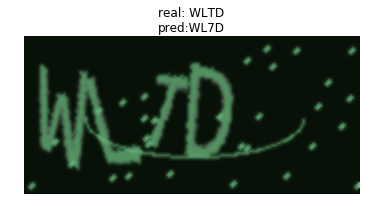

Epoch 38/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.58679676056


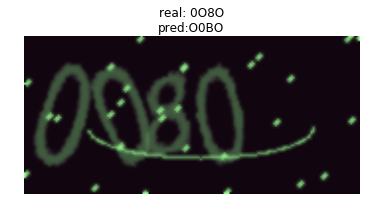

Epoch 39/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.17124176025


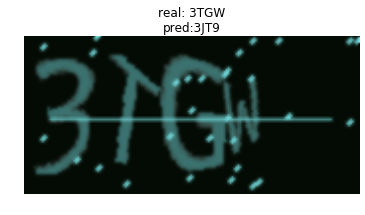

Epoch 40/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

2.9623708725


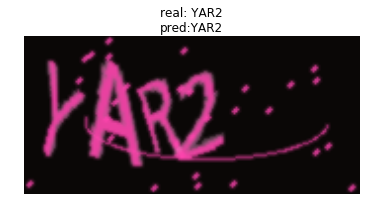

Epoch 41/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

2.23898124695


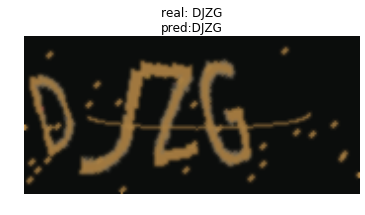

Epoch 42/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

2.89238452911


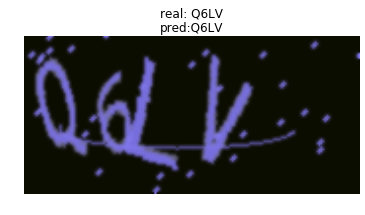

Epoch 43/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

4.05696964264


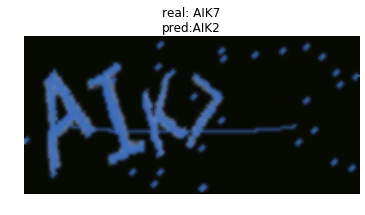

Epoch 44/50: 100%|██████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]

3.14633083344


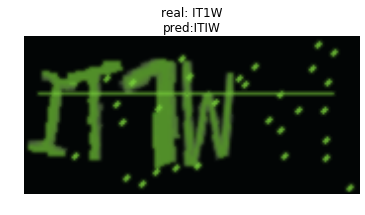

Epoch 45/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.07it/s]

2.96610927582


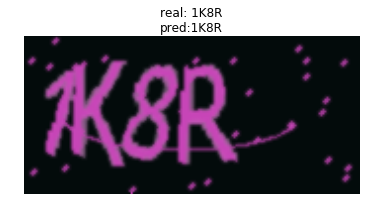

Epoch 46/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.56970214844


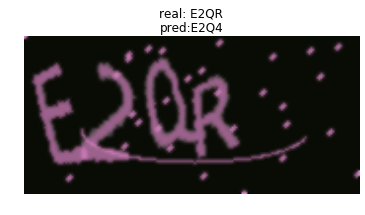

Epoch 47/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

2.89777946472


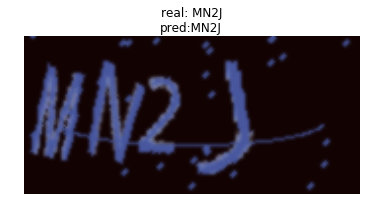

Epoch 48/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

2.63532829285


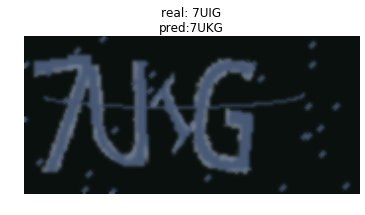

Epoch 49/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.02820682526


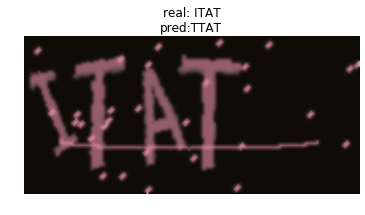

Epoch 50/50: 100%|██████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]

3.16559505463


In [15]:
for epoch_number in range(num_epox):
    test_with_image()
    for batch in tqdm(
            range(num_batches_per_epoch),
            ncols=90,
            smoothing=1,
            desc='Epoch {}/{}'.format((epoch_number + 1), num_epox)):
        x, y = next(data_generator(batch_size))
        
        minibatch_losses = []
        trainer.train_minibatch(
            {
                input_placeholder: x,
                output_placeholder0: y[0],
                output_placeholder1: y[1],
                output_placeholder2: y[2],
                output_placeholder3: y[3]
            }
        )
        minibatch_losses.append(trainer.previous_minibatch_loss_average)
    print(np.mean(minibatch_losses))

Save the model weights to replicate results.
If you want the model and the weights kindly drop an email. The file is too big (300+ MB) to be pushed to github. Also, it doesnt make sense in VCS-ing the weights.

In [40]:
z.save('model_weights.dnn')